In [1]:
import os
import glob
import random
import re
import yaml
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as mpatches

# Report STAR log

Merge STAR log of all samples

In [2]:
array = []
for path in sorted(glob.glob("results/prepare/star/mapped/*/Log.final.out")):
    sample = path.split("/")[-2]
    names = []
    values = []
    with open(path) as f:
        for line in f:
            if "|" not in line:
                continue
            name, value = line.strip("\n").split("|")
            names.append(name.strip())
            values.append(value.strip())
    s = pd.Series(values, index=names)
    s.name = sample
    array.append(s)
dat = pd.DataFrame(array)
dat.index.name = "Sample"
dat.to_csv("results/summary.prepare.star.tsv", sep="\t")
dat.head()

,Started job on,Started mapping on,Finished on,"Mapping speed, Million of reads per hour",Number of input reads,Average input read length,Uniquely mapped reads number,Uniquely mapped reads %,Average mapped length,Number of splices: Total,...,Number of reads mapped to too many loci,% of reads mapped to too many loci,Number of reads unmapped: too many mismatches,% of reads unmapped: too many mismatches,Number of reads unmapped: too short,% of reads unmapped: too short,Number of reads unmapped: other,% of reads unmapped: other,Number of chimeric reads,% of chimeric reads
Sample,,,,,,,,,,,,,,,,,,,,,
Ad_Br_Fe_1,Jul 29 17:40:17,Jul 29 17:42:29,Jul 29 18:30:36,75.46,60518607,300,51423675,84.97%,299.88,21270763,...,4738560,7.83%,2339890,3.87%,1989543,3.29%,26939,0.04%,0,0.00%
Ad_Br_Fe_2,Jul 29 16:43:25,Jul 29 16:52:22,Jul 29 17:41:39,74.19,60938637,300,52746351,86.56%,299.92,39113855,...,3869890,6.35%,2270290,3.73%,2018977,3.31%,33129,0.05%,0,0.00%
Ad_Br_Fe_3,Jul 30 02:10:26,Jul 30 02:11:36,Jul 30 02:37:21,95.75,41090797,300,31324962,76.23%,299.95,26525160,...,5875668,14.30%,1699882,4.14%,2174753,5.29%,15532,0.04%,0,0.00%
Ad_Br_Fe_4,Jul 30 01:55:03,Jul 30 01:58:15,Jul 30 02:36:41,64.06,41033467,300,33258314,81.05%,299.95,29431733,...,3897968,9.50%,1825364,4.45%,2025962,4.94%,25859,0.06%,0,0.00%
Ad_Br_Ma_1,Jul 29 19:47:37,Jul 29 19:52:33,Jul 29 20:29:57,81.14,50574573,300,45449682,89.87%,299.91,32638134,...,2715926,5.37%,1211639,2.40%,1179822,2.33%,17504,0.03%,0,0.00%


# Plot gene abund

    1. FPKM correlation heatmap
    2. FPKM correlation clustermap
    3. FPKM clustermap

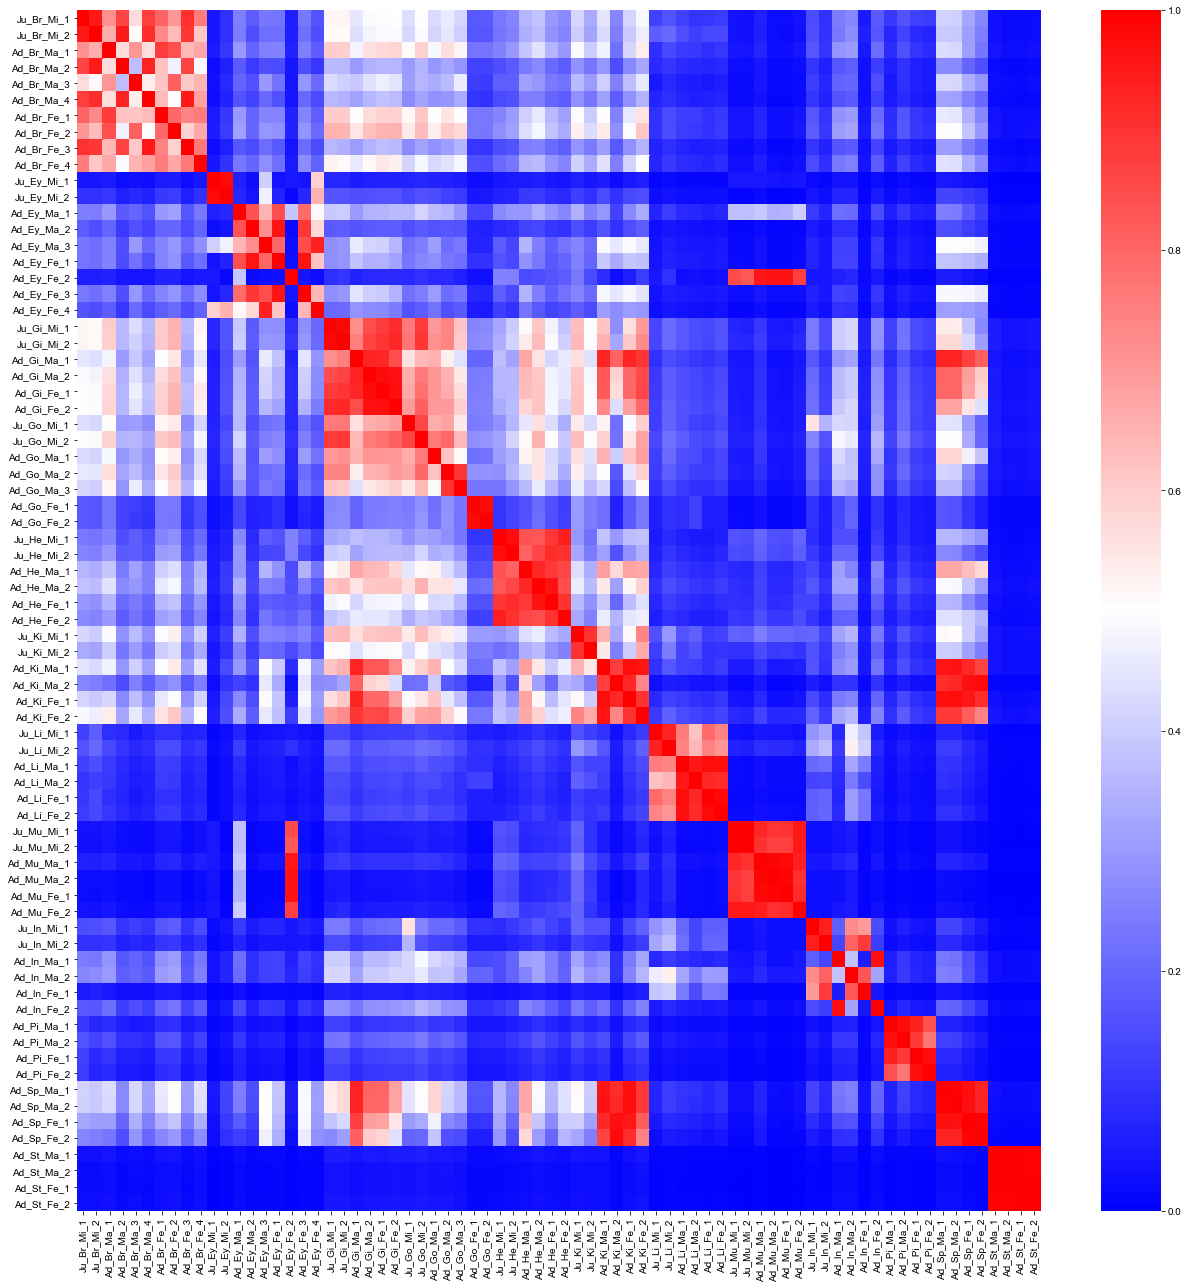

In [7]:
infile = "results/prepare/stringtie/gene_abund.tsv"
outfile = "figures/prepare.gene_abund.corr.heatmap.pdf"

dat = pd.read_csv(infile, sep="\t", index_col=0)
corr = dat.corr()
plt.figure(figsize=(18, 18))
seaborn.heatmap(corr, cmap="bwr", vmin=0, vmax=1)
plt.tight_layout()
plt.savefig(outfile, dpi=300)

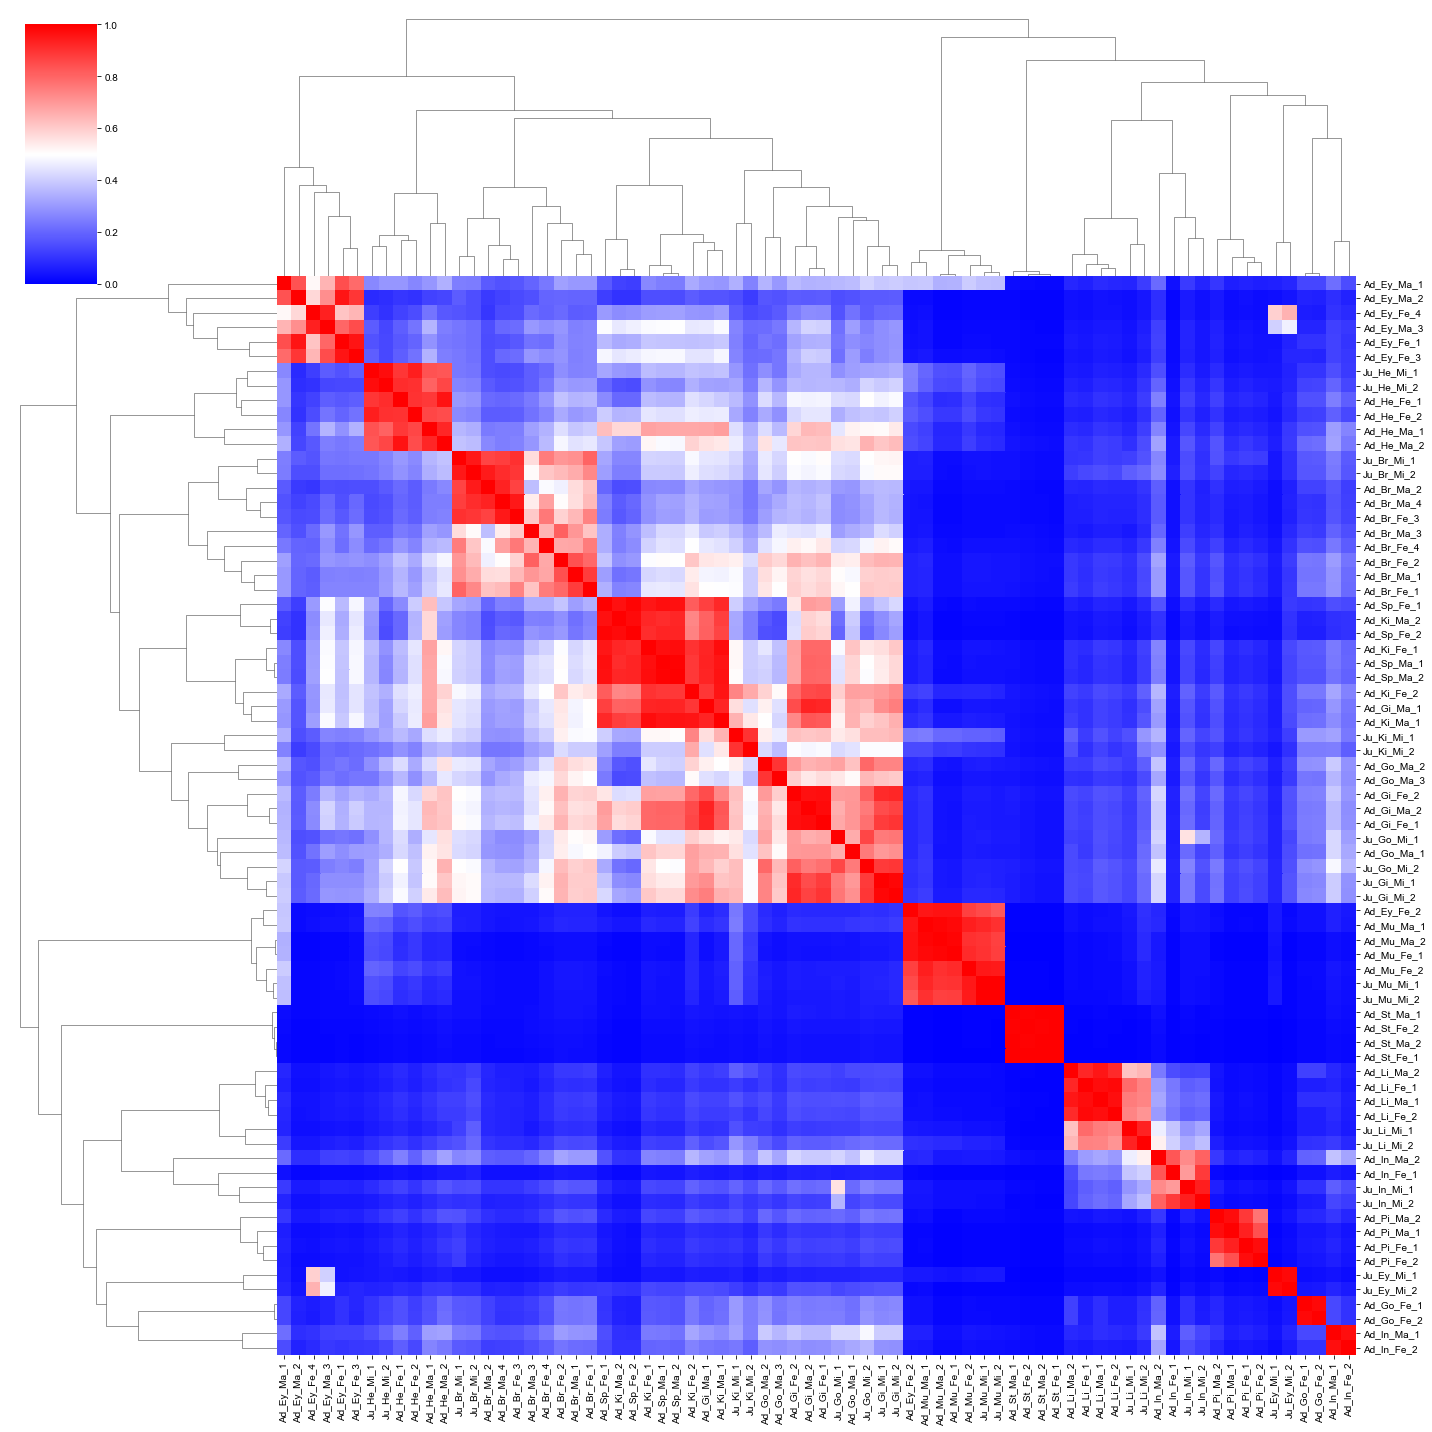

In [8]:
infile = "results/prepare/stringtie/gene_abund.tsv"
outfile = "figures/prepare.gene_abund.corr.clustermap.pdf"

dat = pd.read_csv(infile, sep="\t", index_col=0)
corr = dat.corr()
ret = seaborn.clustermap(corr, cmap="bwr", vmin=0, vmax=1, figsize=(20, 20))
ret.savefig(outfile, dpi=300)

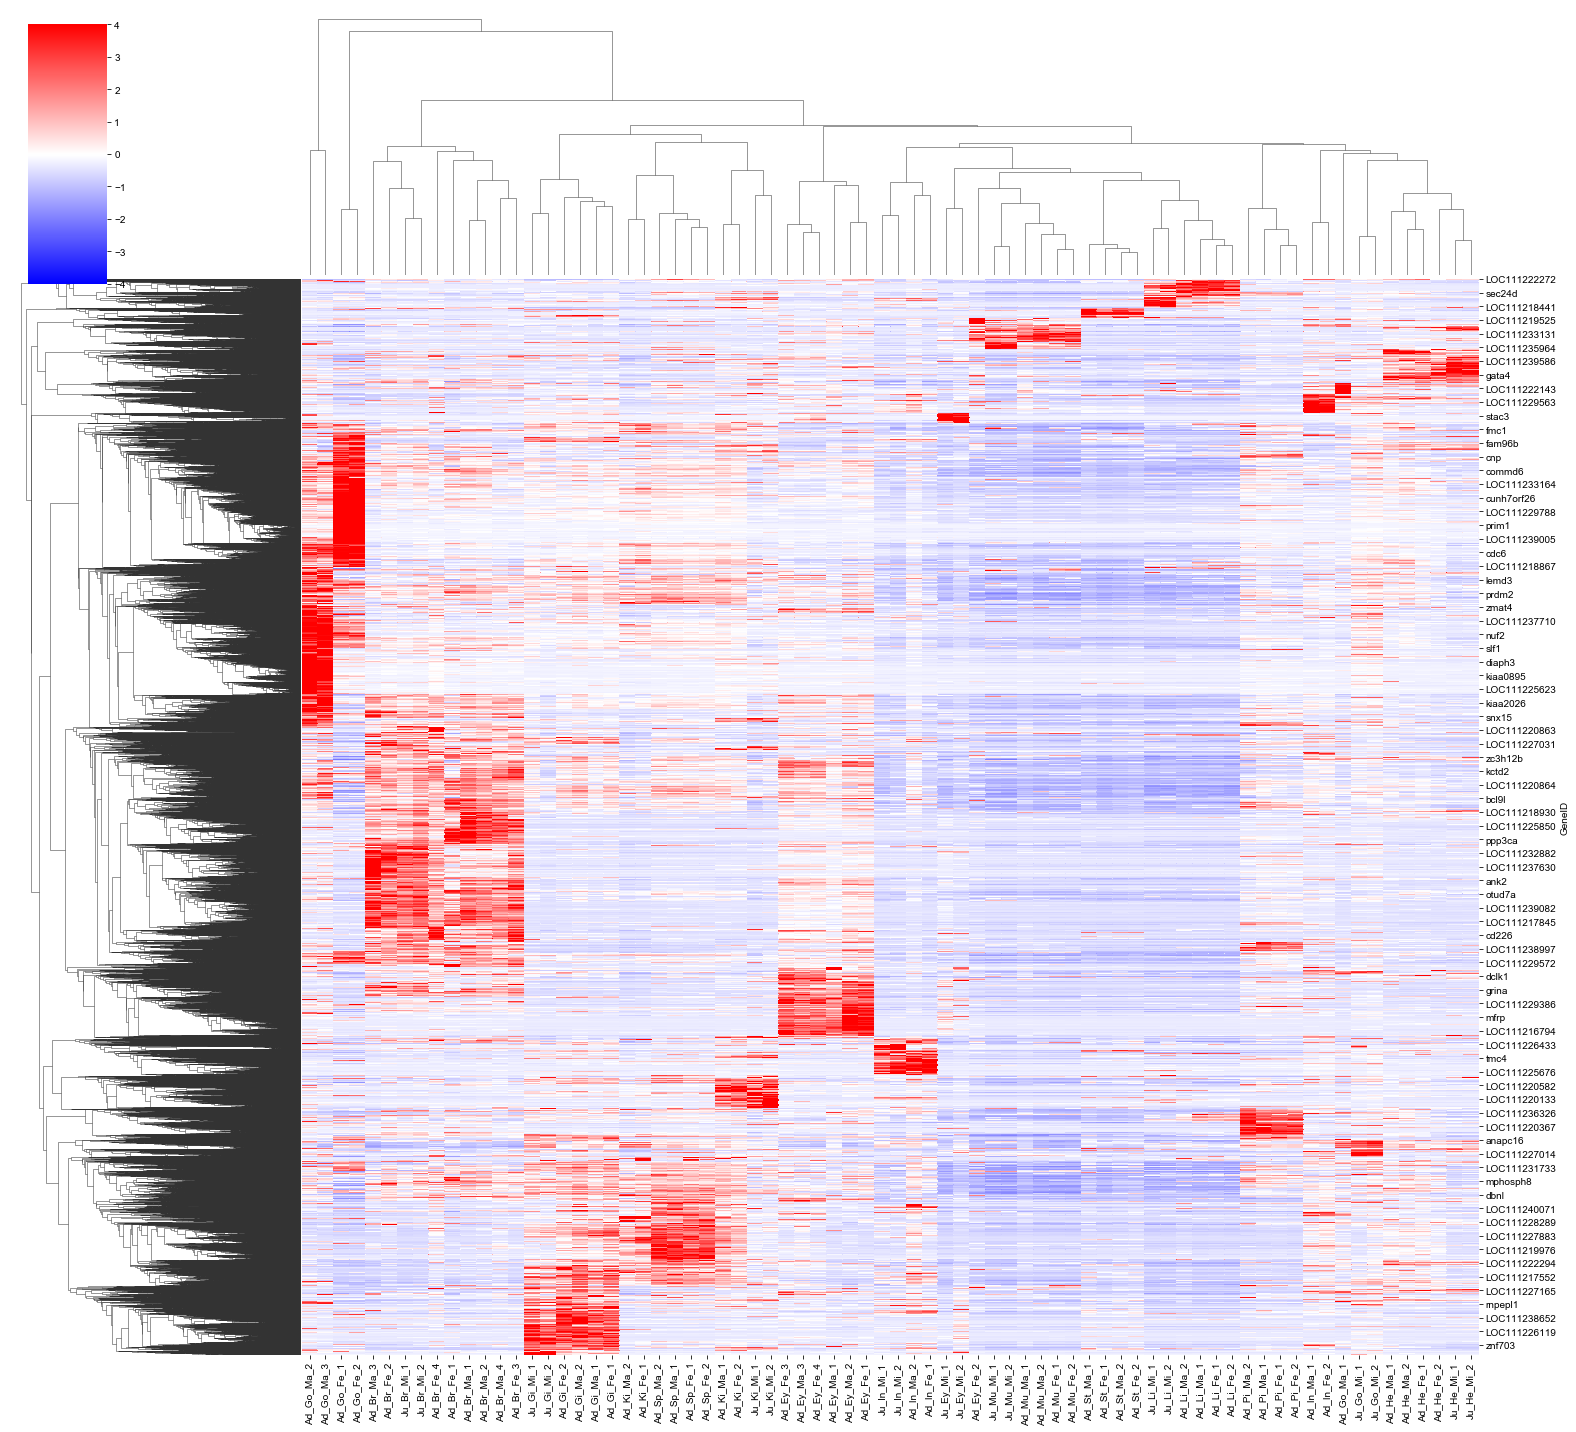

In [9]:
infile = "results/prepare/stringtie/gene_abund.tsv"
outfile = "figures/prepare.gene_abund.clustermap.pdf"

dat = pd.read_csv(infile, sep="\t", index_col=0)
dat1 = dat[dat.max(axis=1) >= 1]
ret = seaborn.clustermap(dat1, z_score=0, cmap="bwr", vmin=-4, vmax=4, figsize=(22, 20))
ret.savefig(outfile, dpi=300)

# Plot raw reads (scatter)

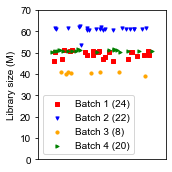

In [28]:
dat = pd.read_csv("results/summary.prepare.star.tsv", sep="\t", index_col=0)

ys = dat["Number of input reads"].values / 1e6
xs = np.random.rand(len(ys)) * 0.8 + 0.1

batches = []
for sample in dat.index:
    path1 = "data/datasets/%s_R1.fastq.gz" % sample
    path2 = os.readlink(path1)
    if "F20FTSCCKF0955_FISgaaE" in path2:
        batches.append(0)
    elif "F20FTSCCKF1558_YUocvE" in path2:
        batches.append(1)
    elif "F21FTSCCKF2946_SERvuzhR" in path2:
        batches.append(2)
    else:
        batches.append(3)

xs1 = []
ys1 = []
xs2 = []
ys2 = []
xs3 = []
ys3 = []
xs4 = []
ys4 = []
for x, y, b in zip(xs, ys, batches):
    if b == 0:
        xs1.append(x)
        ys1.append(y)
    elif b == 1:
        xs2.append(x)
        ys2.append(y)
    elif b == 2:
        xs3.append(x)
        ys3.append(y)
    else:
        xs4.append(x)
        ys4.append(y)
        
plt.figure(figsize=(2.5, 2.5))
plt.scatter(xs1, ys1, color="red", marker="s", s=10, label="Batch 1 (%d)" % len(xs1))
plt.scatter(xs2, ys2, color="blue", marker="v", s=10, label="Batch 2 (%d)" % len(xs2))
plt.scatter(xs3, ys3, color="orange", marker="o", s=10, label="Batch 3 (%d)" % len(xs3))
plt.scatter(xs4, ys4, color="green", marker=">", s=10, label="Batch 4 (%d)" % len(xs4))

plt.xlim(0, 1)
plt.xticks([])
plt.ylim(0, 70)
plt.yticks(np.arange(0, 80, 10))
plt.ylabel("Library size (M)")
plt.legend(frameon=True)

plt.tight_layout()
plt.savefig("figures/prepare.raw_read.scatter.png", dpi=300)

# 2021-03-23 Plot summary

In [2]:
dat = pd.read_excel("gaotishi.ngs.summary.xlsx", index_col=0)

In [3]:
dat.columns

Index(['RawRead', 'UniqueMapped', 'UniqueMappedRatio', 'MultiMapped',
       'MultiMappedRatio', 'UniqueMapped2', 'UniqueMappedRatio2',
       'MultiMapped2', 'MultiMappedRatio2', 'TooManyMismatch2',
       'TooManyMismatchRatio2', 'TooShort2', 'TooShortRatio2', 'FilteredRead',
       'FilteredRatio', 'UniqueRead', 'UniqueRatio', 'FeatureAssigned',
       'FeatureAssignedRatio', 'FeatureNoFeature', 'FeatureNoFeatureRatio',
       'FeatureAmbiguity', 'FeatureAmbiguityRatio', 'FeatureAssignedUniq',
       'FeatureAssignedUniqRatio', 'FeatureNoFeatureUniq',
       'FeatureNoFeatureUniqRatio', 'FeatureAmbiguityUniq',
       'FeatureAmbiguityUniqRatio'],
      dtype='object')

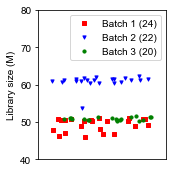

In [4]:
# plot the raw read scatter

ys = dat["RawRead"].values / 1e6
xs = np.random.rand(len(ys)) * 0.8 + 0.1

batches = []
for sample in samples:
    path1 = "data/datasets/%s_R1.fastq.gz" % sample
    path2 = os.readlink(path1)
    if "F20FTSCCKF0955_FISgaaE" in path2:
        batches.append(0)
    elif "F20FTSCCKF1558_YUocvE" in path2:
        batches.append(1)
    else:
        batches.append(2)

xs1 = []
ys1 = []
xs2 = []
ys2 = []
xs3 = []
ys3 = []
for x, y, b in zip(xs, ys, batches):
    if b == 0:
        xs1.append(x)
        ys1.append(y)
    elif b == 1:
        xs2.append(x)
        ys2.append(y)
    else:
        xs3.append(x)
        ys3.append(y)
        
plt.figure(figsize=(2.5, 2.5))
plt.scatter(xs1, ys1, color="red", marker="s", s=10, label="Batch 1 (%d)" % len(xs1))
plt.scatter(xs2, ys2, color="blue", marker="v", s=10, label="Batch 2 (%d)" % len(xs2))
plt.scatter(xs3, ys3, color="green", marker="o", s=10, label="Batch 3 (%d)" % len(xs3))
plt.xlim(0, 1)
plt.xticks([])
plt.ylim(40, 80)
plt.yticks([40, 50, 60, 70, 80])
plt.ylabel("Library size (M)")
plt.legend(frameon=True)

plt.tight_layout()
if True:
    plt.show()
else:
    plt.savefig("figures/raw_read.scatter.png", dpi=300)
plt.close()

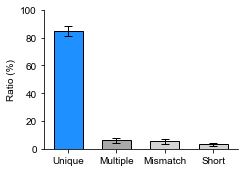

In [11]:
# plot ratio
tmp = dat[["UniqueMappedRatio2", "MultiMappedRatio2", "TooManyMismatchRatio2", "TooShortRatio2"]] * 100
ys = tmp.mean()
ye = tmp.std()
xs = [0, 1, 2, 3]
xticks = ["Unique", "Multiple", "Mismatch", "Short"]
plt.figure(figsize=(3.5, 2.5))
plt.bar(xs, ys, yerr=ye, width=0.6, color=["dodgerblue", "darkgrey", "lightgrey", "lightgrey"], lw=1, 
        edgecolor="black", error_kw={"capsize": 4, "linewidth": 1, "capthick": 1})
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# plt.gca().spines["bottom"].set_visible(False)

plt.xlim(-0.5, 3.5)
# plt.xlabel("Mapping")
plt.xticks(xs, xticks, rotation=0)
plt.ylim(0, 100)
plt.ylabel("Ratio (%)")
# plt.legend()
plt.tight_layout()
if True:
    plt.show()
else:
    plt.savefig("figures/mapping.ratio.bar.png", dpi=300)
plt.close()

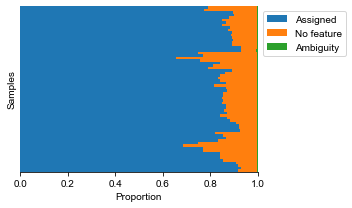

In [12]:
bs1 = np.zeros(len(dat))
xs1 = dat["FeatureAssignedRatio"].values
bs2 = xs1 + bs1
xs2 = dat["FeatureNoFeatureRatio"].values
bs3 = xs2 + bs2
xs3 = dat["FeatureAmbiguityRatio"].values
ys = np.arange(len(dat))[::-1]

plt.figure(figsize=(5, 3))
plt.barh(ys, xs1, left=bs1, height=1, label="Assigned")
plt.barh(ys, xs2, left=bs2, height=1, label="No feature")
plt.barh(ys, xs3, left=bs3, height=1, label="Ambiguity")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlim(0, 1)
plt.xlabel("Proportion")
plt.ylim(min(ys) - 0.5, max(ys) + 0.5)
# plt.yticks(ys, dat.index)
plt.yticks([])
plt.ylabel("Samples")
# plt.grid(ls="--", lw=1, color="lightgray")
plt.legend(loc="upper left", bbox_to_anchor=[1, 1])
plt.tight_layout(rect=(0, 0, 1, 1))
if True:
    plt.show()
else:
    plt.savefig("figures/feature.distribution.png", dpi=300)
plt.close()

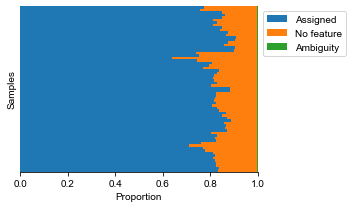

In [14]:
bs1 = np.zeros(len(dat))
xs1 = dat["FeatureAssignedUniqRatio"].values
bs2 = xs1 + bs1
xs2 = dat["FeatureNoFeatureUniqRatio"].values
bs3 = xs2 + bs2
xs3 = dat["FeatureAmbiguityUniqRatio"].values
ys = np.arange(len(dat))[::-1]

plt.figure(figsize=(5, 3))
plt.barh(ys, xs1, left=bs1, height=1, label="Assigned")
plt.barh(ys, xs2, left=bs2, height=1, label="No feature")
plt.barh(ys, xs3, left=bs3, height=1, label="Ambiguity")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlim(0, 1)
plt.xlabel("Proportion")
plt.ylim(min(ys) - 0.5, max(ys) + 0.5)
# plt.yticks(ys, dat.index)
plt.yticks([])
plt.ylabel("Samples")
# plt.grid(ls="--", lw=1, color="lightgray")
plt.legend(loc="upper left", bbox_to_anchor=[1, 1])
plt.tight_layout(rect=(0, 0, 1, 1))
if True:
    plt.show()
else:
    plt.savefig("figures/feature.distribution.uniq.png", dpi=300)
plt.close()

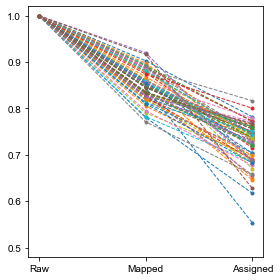

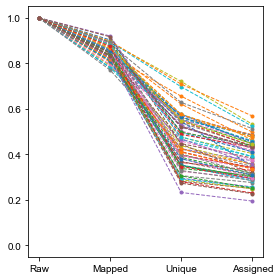

In [37]:
plt.figure(figsize=(4, 4))
for i in range(len(dat)):
    values = dat.iloc[i]
    ys = [
        1,
        values["UniqueMapped2"] / values["RawRead"],
        values["FeatureAssigned"] / values["RawRead"]
    ]
    xs = np.arange(len(ys))
    plt.plot(xs, ys, ls="--", lw=1, marker=".")
plt.xticks([0, 1, 2], ["Raw", "Mapped", "Assigned"])
plt.ylim(0.48, 1.02)
plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 4))
for i in range(len(dat)):
    values = dat.iloc[i]
    ys = [
        1,
        values["UniqueMapped2"] / values["RawRead"],
        values["UniqueRead"] / values["RawRead"],
        values["FeatureAssignedUniq"] / values["RawRead"]
    ]
    xs = np.arange(len(ys))
    plt.plot(xs, ys, ls="--", lw=1, marker=".")
plt.xticks([0, 1, 2, 3], ["Raw", "Mapped", "Unique", "Assigned"])
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()

# 2021-12-29 STAR log

In [19]:
array = []
for path in glob.glob("results/mapping/star/mapped.1st.local/*/Log.final.out"):
    s = pd.Series(dtype=object)
    s.name = path.split("/")[-2]
    with open(path) as f:
        for line in f:
            row = line.strip("\n").split("\t")
            if len(row) != 2:
                continue
            k, v = row
            k = k[:-2].strip()
            v = v.strip()
            s[k] = v
    array.append(s)
dat = pd.DataFrame(array)
dat = dat.sort_index()
dat.index.name = "Sample"
dat.to_csv("results/summary.star.mapped.1st.tsv", sep="\t")

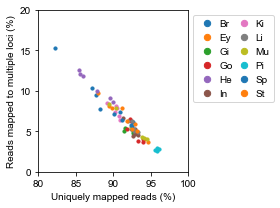

In [124]:
tissues = list(sorted(set([v.split("_")[1] for v in dat.index])))
plt.figure(figsize=(4, 3))
for i, t in enumerate(tissues):
    tmp = dat[[v.split("_")[1] == t for v in dat.index]]
    xs = [float(v[:-1]) for v in tmp["Uniquely mapped reads %"]]
    ys = [float(v[:-1]) for v in tmp["% of reads mapped to multiple loci"]]
    plt.scatter(xs, ys, s=10, color="C%d" % i, label=t)
plt.xlim(80, 100)
plt.ylim(0, 20)   

plt.yticks(np.arange(0, 21, 5))
plt.xlabel("Uniquely mapped reads (%)")
plt.ylabel("Reads mapped to multiple loci (%)")
plt.legend(ncol=2, bbox_to_anchor=(1, 1), loc="upper left", markerscale=2, 
           columnspacing=0.1, handletextpad=0.2, frameon=True)
plt.tight_layout()
plt.savefig("figures/stat.star.mapped.1st.png", dpi=300)

In [2]:
array = []
for path in glob.glob("results/mapping/star/mapped.2nd.local/*/Log.final.out"):
    s = pd.Series(dtype=object)
    s.name = path.split("/")[-2]
    with open(path) as f:
        for line in f:
            row = line.strip("\n").split("\t")
            if len(row) != 2:
                continue
            k, v = row
            k = k[:-2].strip()
            v = v.strip()
            s[k] = v
    array.append(s)
dat = pd.DataFrame(array)
dat = dat.sort_index()
dat.index.name = "Sample"
dat.to_csv("results/summary.star.mapped.2nd.tsv", sep="\t")

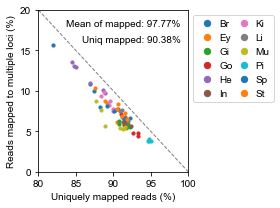

In [22]:
xs = [float(v[:-1]) for v in dat["Uniquely mapped reads %"]]
ys = [float(v[:-1]) for v in dat["% of reads mapped to multiple loci"]]
zs = np.array(xs) + np.array(ys)
m = np.mean(zs)
mx = np.mean(xs)


tissues = list(sorted(set([v.split("_")[1] for v in dat.index])))
plt.figure(figsize=(4, 3))
for i, t in enumerate(tissues):
    tmp = dat[[v.split("_")[1] == t for v in dat.index]]
    xs = [float(v[:-1]) for v in tmp["Uniquely mapped reads %"]]
    ys = [float(v[:-1]) for v in tmp["% of reads mapped to multiple loci"]]
    plt.scatter(xs, ys, s=10, color="C%d" % i, label=t)
plt.plot([80, 100], [20, 0], lw=1, color="grey", ls="--")
plt.xlim(80, 100)
plt.ylim(0, 20)   
plt.text(99, 18, "Mean of mapped: %.2f%%" % m, ha="right")
plt.text(99, 16, "Uniq mapped: %.2f%%" % mx, ha="right")
plt.yticks(np.arange(0, 21, 5))
plt.xlabel("Uniquely mapped reads (%)")
plt.ylabel("Reads mapped to multiple loci (%)")
plt.legend(ncol=2, bbox_to_anchor=(1, 1), loc="upper left", markerscale=2, 
           columnspacing=0.1, handletextpad=0.2, frameon=True)
plt.tight_layout()
plt.savefig("figures/stat.star.mapped.2nd.png", dpi=300)